In [28]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

qa_answers = pd.read_csv("/Users/sapuantalaspay/vs_projects/introML/final_ML/data/qa_answers_rows.csv")
qa_index = pd.read_csv("/Users/sapuantalaspay/vs_projects/introML/final_ML/data/qa_index_rows.csv")
qa_paraphrase_done = pd.read_csv("/Users/sapuantalaspay/vs_projects/introML/final_ML/data/qa_paraphrase_done_rows.csv")

qa_answers.shape, qa_index.shape, qa_paraphrase_done.shape

((6111, 7), (16395, 9), (2462, 2))

In [29]:
from IPython.display import display

display(qa_answers.head(3))
display(qa_index.head(3))
display(qa_paraphrase_done.head(3))

print("qa_answers columns:", list(qa_answers.columns))
print("qa_index columns:", list(qa_index.columns))
print("qa_paraphrase_done columns:", list(qa_paraphrase_done.columns))

,answer_id,answer,lang,meta,created_at,answer_hash,answer_clean
0,1,Один из самых главных аспектов нашего универси...,ru,"{""source_chunk_id"":1}",2025-12-13 13:43:15.41439+00,a6a296af2adfbc3268da4d67d6e72741edb53947,Один из самых главных аспектов нашего универси...
1,2,Deadline әр пәннен мұғалімдер өз тапсырмаларын...,kk,"{""source_chunk_id"":2}",2025-12-13 13:43:15.41439+00,367839b81ec3db4d7e39265e0d09f6884d24a735,Deadline әр пәннен мұғалімдер өз тапсырмаларын...
2,3,SDU университеті студенттердің тамақтануына ер...,kk,"{""source_chunk_id"":3}",2025-12-13 13:43:15.41439+00,fb38f46429192deebf5d9131c32ea900d692e7a1,SDU университеті студенттердің тамақтануына ер...


,index_id,answer_id,lang,search_text,embedding,weight,meta,created_at,search_hash
0,1,1,ru,Клубы,"[-0.03269642,0.031560563,-0.01978282,0.0055677...",1,"{""source"":""rules"",""src_chunk_id"":1}",2025-12-13 13:43:34.104707+00,1d0a73dad41cd9e145a8fc43e42a5ea5c1164d9d
1,2,1,ru,Клубы что это такое объясни анықтама,"[0.0031500468,-0.0045268345,-0.09593522,0.0146...",1,"{""source"":""rules"",""src_chunk_id"":1}",2025-12-13 13:43:34.104707+00,9831e154e42ef75533325806c1f366847eaad857
2,3,2,kk,Deadline,"[0.01789701,0.042790506,0.024193846,-0.0052473...",1,"{""source"":""rules"",""src_chunk_id"":2}",2025-12-13 13:43:34.104707+00,9da63fbd49a8b9cc112db4a1290d18ff29820fe0


,base_search_hash,created_at
0,000b6931190c8f47dea7fae7e20b87c5308689dd,2025-12-13 21:51:56.83514+00
1,00111074c3d6fcc47f9906a7bc7ed39753781c0b,2025-12-13 21:51:56.83514+00
2,002d6b8541012580ec8bb9a82446586db31f7dbd,2025-12-14 06:29:06.198647+00


qa_answers columns: ['answer_id', 'answer', 'lang', 'meta', 'created_at', 'answer_hash', 'answer_clean']
qa_index columns: ['index_id', 'answer_id', 'lang', 'search_text', 'embedding', 'weight', 'meta', 'created_at', 'search_hash']
qa_paraphrase_done columns: ['base_search_hash', 'created_at']


In [30]:
for df_ in [qa_answers, qa_index, qa_paraphrase_done]:
    if "created_at" in df_.columns:
        df_["created_at"] = pd.to_datetime(df_["created_at"], errors="coerce")
        df_["created_day"] = df_["created_at"].dt.date

qa_answers["answer_chars"] = qa_answers["answer"].fillna("").astype(str).str.len()
qa_answers["answer_words"] = qa_answers["answer"].fillna("").astype(str).str.split().str.len()

qa_index["query_chars"] = qa_index["search_text"].fillna("").astype(str).str.len()
qa_index["query_words"] = qa_index["search_text"].fillna("").astype(str).str.split().str.len()

qa_answers[["answer_chars","answer_words"]].describe(), qa_index[["query_chars","query_words"]].describe()

(       answer_chars  answer_words
 count   6111.000000   6111.000000
 mean     247.039273     35.233186
 std      186.223360     26.253644
 min        1.000000      1.000000
 25%      122.000000     18.000000
 50%      199.000000     29.000000
 75%      317.000000     45.000000
 max     1877.000000    322.000000,
         query_chars   query_words
 count  16395.000000  16395.000000
 mean      44.321013      6.787984
 std       19.142588      2.943565
 min        5.000000      1.000000
 25%       33.000000      5.000000
 50%       41.000000      6.000000
 75%       51.000000      8.000000
 max      259.000000     42.000000)

In [31]:
df = qa_index.merge(
    qa_answers[["answer_id","answer","answer_clean","lang","answer_hash"]],
    on="answer_id",
    how="left",
    suffixes=("_q","_a")
)

print("Join shape:", df.shape)
print("Missing answers after join (%):", round(100*df["answer"].isna().mean(), 2))
df.head(3)

Join shape: (16395, 16)
Missing answers after join (%): 0.0


,index_id,answer_id,lang_q,search_text,embedding,weight,meta,created_at,search_hash,created_day,query_chars,query_words,answer,answer_clean,lang_a,answer_hash
0,1,1,ru,Клубы,"[-0.03269642,0.031560563,-0.01978282,0.0055677...",1,"{""source"":""rules"",""src_chunk_id"":1}",2025-12-13 13:43:34.104707+00:00,1d0a73dad41cd9e145a8fc43e42a5ea5c1164d9d,2025-12-13,5,1,Один из самых главных аспектов нашего универси...,Один из самых главных аспектов нашего универси...,ru,a6a296af2adfbc3268da4d67d6e72741edb53947
1,2,1,ru,Клубы что это такое объясни анықтама,"[0.0031500468,-0.0045268345,-0.09593522,0.0146...",1,"{""source"":""rules"",""src_chunk_id"":1}",2025-12-13 13:43:34.104707+00:00,9831e154e42ef75533325806c1f366847eaad857,2025-12-13,36,6,Один из самых главных аспектов нашего универси...,Один из самых главных аспектов нашего универси...,ru,a6a296af2adfbc3268da4d67d6e72741edb53947
2,3,2,kk,Deadline,"[0.01789701,0.042790506,0.024193846,-0.0052473...",1,"{""source"":""rules"",""src_chunk_id"":2}",2025-12-13 13:43:34.104707+00:00,9da63fbd49a8b9cc112db4a1290d18ff29820fe0,2025-12-13,8,1,Deadline әр пәннен мұғалімдер өз тапсырмаларын...,Deadline әр пәннен мұғалімдер өз тапсырмаларын...,kk,367839b81ec3db4d7e39265e0d09f6884d24a735


In [32]:
overview = pd.DataFrame([{
    "answers_rows": len(qa_answers),
    "index_rows": len(qa_index),
    "paraphrase_done_rows": len(qa_paraphrase_done),
    "unique_answers_total": qa_answers["answer_id"].nunique(),
    "unique_answers_in_index": qa_index["answer_id"].nunique(),
    "coverage_answers_in_index_%": round(
        100 * qa_index["answer_id"].nunique() / max(1, qa_answers["answer_id"].nunique()), 2
    ),
    "unique_answer_hash": qa_answers["answer_hash"].nunique(dropna=True) if "answer_hash" in qa_answers.columns else None,
    "unique_search_hash": qa_index["search_hash"].nunique(dropna=True) if "search_hash" in qa_index.columns else None,
}])
overview

,answers_rows,index_rows,paraphrase_done_rows,unique_answers_total,unique_answers_in_index,coverage_answers_in_index_%,unique_answer_hash,unique_search_hash
0,6111,16395,2462,6111,6090,99.66,6111,16395


In [33]:
quality = pd.DataFrame([{
    "answers_null_lang_%": round(100*qa_answers["lang"].isna().mean(), 2) if "lang" in qa_answers.columns else None,
    "index_null_lang_%": round(100*qa_index["lang"].isna().mean(), 2) if "lang" in qa_index.columns else None,
    "short_answers_<30chars_%": round(100*(qa_answers["answer_chars"] < 30).mean(), 2),
    "short_queries_<10chars_%": round(100*(qa_index["query_chars"] < 10).mean(), 2),
    "dup_answers_by_hash": int(len(qa_answers) - qa_answers["answer_hash"].nunique(dropna=True)) if "answer_hash" in qa_answers.columns else None,
    "dup_queries_by_hash": int(len(qa_index) - qa_index["search_hash"].nunique(dropna=True)) if "search_hash" in qa_index.columns else None,
}])
quality

,answers_null_lang_%,index_null_lang_%,short_answers_<30chars_%,short_queries_<10chars_%,dup_answers_by_hash,dup_queries_by_hash
0,0.0,0.0,1.82,0.02,0,0


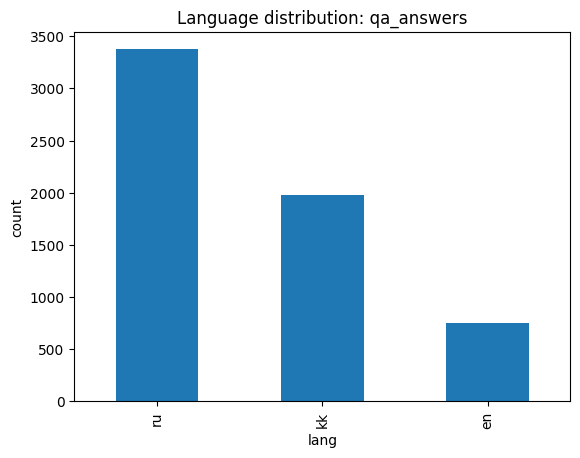

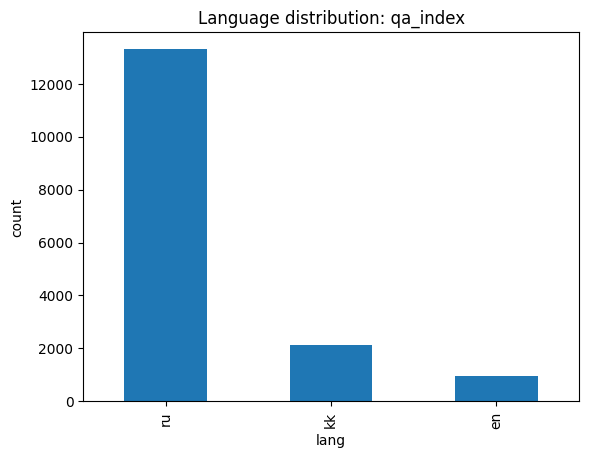

In [34]:
if "lang" in qa_answers.columns:
    qa_answers["lang"].fillna("NULL").value_counts().plot(kind="bar")
    plt.title("Language distribution: qa_answers")
    plt.ylabel("count")
    plt.show()

if "lang" in qa_index.columns:
    qa_index["lang"].fillna("NULL").value_counts().plot(kind="bar")
    plt.title("Language distribution: qa_index")
    plt.ylabel("count")
    plt.show()

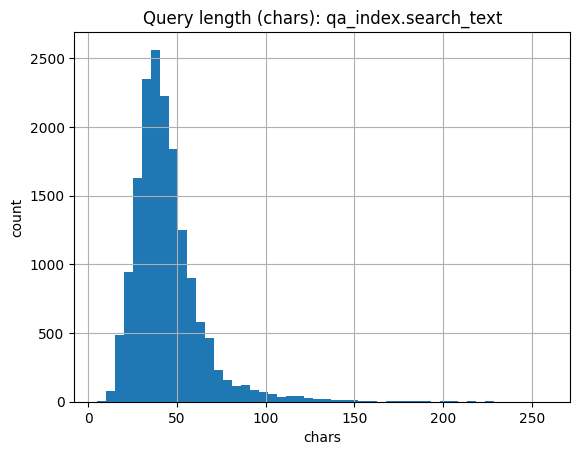

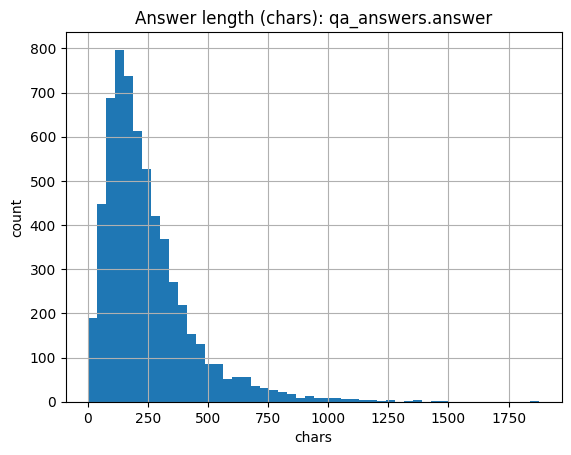

In [35]:
qa_index["query_chars"].hist(bins=50)
plt.title("Query length (chars): qa_index.search_text")
plt.xlabel("chars")
plt.ylabel("count")
plt.show()

qa_answers["answer_chars"].hist(bins=50)
plt.title("Answer length (chars): qa_answers.answer")
plt.xlabel("chars")
plt.ylabel("count")
plt.show()

count    6090.000000
mean        2.692118
std         4.156049
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        26.000000
Name: queries_per_answer, dtype: float64


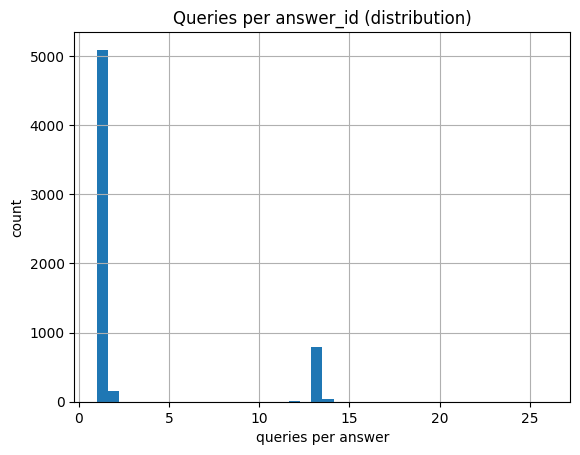

answer_id
293     26
412     17
1634    14
1254    14
266     14
1810    14
1086    14
1241    14
1234    14
275     14
Name: queries_per_answer, dtype: int64

In [36]:
qpa = qa_index.groupby("answer_id").size().rename("queries_per_answer")

print(qpa.describe())

qpa.hist(bins=40)
plt.title("Queries per answer_id (distribution)")
plt.xlabel("queries per answer")
plt.ylabel("count")
plt.show()

qpa.sort_values(ascending=False).head(10)

Lang mismatch rate (%): 0.0


lang_a,en,kk,ru
lang_q,,,
en,980,0,0
kk,0,2129,0
ru,0,0,13286


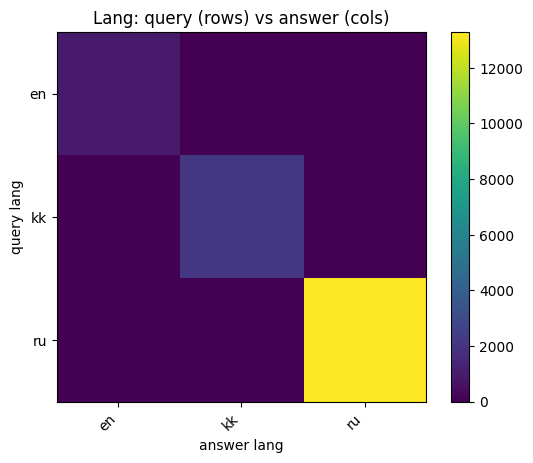

In [37]:
if "lang_q" in df.columns and "lang_a" in df.columns:
    mismatch = (df["lang_q"].fillna("NULL") != df["lang_a"].fillna("NULL")).mean()
    print("Lang mismatch rate (%):", round(100*mismatch, 2))

    ctab = pd.crosstab(df["lang_q"].fillna("NULL"), df["lang_a"].fillna("NULL"))
    display(ctab)

    plt.imshow(ctab.values)
    plt.title("Lang: query (rows) vs answer (cols)")
    plt.xlabel("answer lang")
    plt.ylabel("query lang")
    plt.xticks(range(len(ctab.columns)), ctab.columns, rotation=45, ha="right")
    plt.yticks(range(len(ctab.index)), ctab.index)
    plt.colorbar()
    plt.show()

,queries_per_answer,answer_chars,answer_words
queries_per_answer,1.000000,-0.005169,0.013090
answer_chars,-0.005169,1.000000,0.975517
answer_words,0.013090,0.975517,1.000000


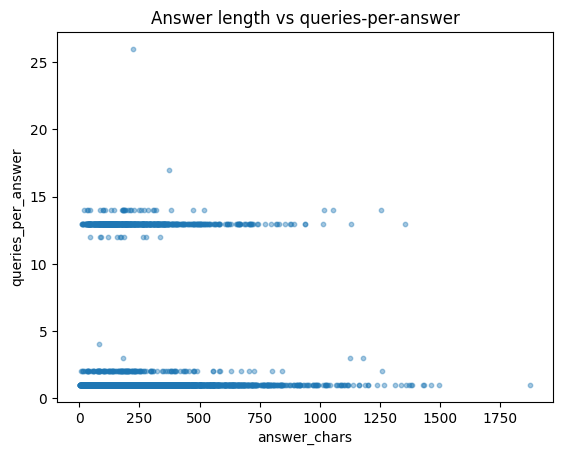

,len_bin,count,mean,median
0,"(0.999, 109.0]",1229,2.834825,1.0
1,"(109.0, 167.0]",1218,2.673235,1.0
2,"(167.0, 240.0]",1217,2.629417,1.0
3,"(240.0, 351.0]",1216,2.637336,1.0
4,"(351.0, 1877.0]",1210,2.684298,1.0


In [38]:
qpa = qa_index.groupby("answer_id").size().rename("queries_per_answer").reset_index()
ans_len = qa_answers[["answer_id","answer_chars","answer_words"]].copy()

qpa2 = qpa.merge(ans_len, on="answer_id", how="left")

corr = qpa2[["queries_per_answer","answer_chars","answer_words"]].corr(numeric_only=True)
display(corr)

plt.scatter(qpa2["answer_chars"], qpa2["queries_per_answer"], s=10, alpha=0.4)
plt.title("Answer length vs queries-per-answer")
plt.xlabel("answer_chars")
plt.ylabel("queries_per_answer")
plt.show()

qpa2["len_bin"] = pd.qcut(qpa2["answer_chars"].fillna(0), q=5, duplicates="drop")
bin_stats = qpa2.groupby("len_bin")["queries_per_answer"].agg(["count","mean","median"]).reset_index()
display(bin_stats)

count    6111.000000
mean        1.798245
std         3.657488
min         0.184337
25%         0.922039
50%         1.057778
75%         1.707039
max       121.000000
Name: clean_ratio, dtype: float64

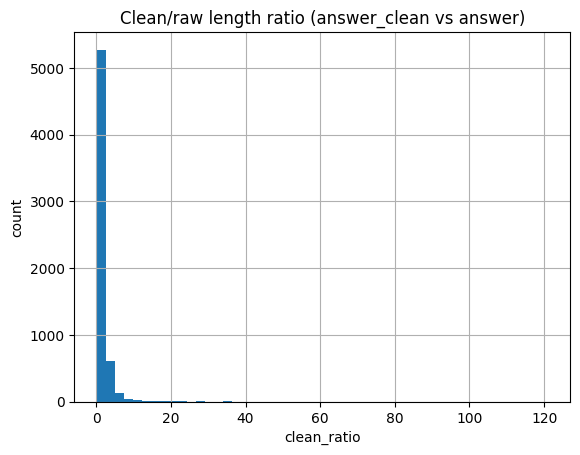

,answer_id,raw_chars,clean_chars,answer,answer_clean
6077,6078,1877,346,The university has many social clubs aimed at ...,The university offers a variety of social club...
626,627,1465,406,Vision клубы тек қана қыз балаларға арналған к...,"Vision клубы тек қыз балаларға арналған, тұлға..."
1768,1769,1429,424,Сүлейман Демирел университетінің Студенттер үй...,Сүлейман Демирел университетінің Студенттер үй...
1197,1198,428,138,"айкайла, шанырак, хайырлысы, СДУдент зубрить, ...",Айкайла - это словарь студенческой жизни с раз...
4426,4427,1385,470,Сдача данного экзамена онлайн невозможна. Экза...,Сдача данного экзамена онлайн невозможна.\n\n-...


In [39]:
if "answer_clean" in qa_answers.columns:
    qa_answers["clean_chars"] = qa_answers["answer_clean"].fillna("").astype(str).str.len()
    qa_answers["raw_chars"] = qa_answers["answer"].fillna("").astype(str).str.len()
    qa_answers["clean_ratio"] = qa_answers["clean_chars"] / qa_answers["raw_chars"].replace(0, np.nan)

    display(qa_answers["clean_ratio"].describe())

    qa_answers["clean_ratio"].dropna().hist(bins=50)
    plt.title("Clean/raw length ratio (answer_clean vs answer)")
    plt.xlabel("clean_ratio")
    plt.ylabel("count")
    plt.show()

    examples = qa_answers.sort_values("clean_ratio").head(5)[["answer_id","raw_chars","clean_chars","answer","answer_clean"]]
    display(examples)